In [1]:
import json
import pandas as pd
from pathlib import Path
from pprint import pprint
import datetime
import time
import numpy as np
import matplotlib as plt

import pandas
import researchpy as rp
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

%matplotlib inline

In [2]:
#path_results = Path('/media/discoD/models/elmo/ner/results_20_epochs_ibm')
#path_results = Path('/media/discoD/models/elmo/ner/results_1_epoch_harem_all_combinations')
path_results = Path('/media/discoD/models/elmo/ner/mestrado/results_harem_10epochs_rtx2080ti/')

In [3]:
for folder in path_results.iterdir():
    print(folder)

/media/discoD/models/elmo/ner/mestrado/results_harem_10epochs_rtx2080ti/harem-ft1epoch_ELMo
/media/discoD/models/elmo/ner/mestrado/results_harem_10epochs_rtx2080ti/harem-ft1epoch_ELMo+CNN
/media/discoD/models/elmo/ner/mestrado/results_harem_10epochs_rtx2080ti/harem-ft1epoch_ELMo+CNN+Embeddings
/media/discoD/models/elmo/ner/mestrado/results_harem_10epochs_rtx2080ti/harem-ft1epoch_ELMo+Embeddings
/media/discoD/models/elmo/ner/mestrado/results_harem_10epochs_rtx2080ti/harem-ft_ELMo
/media/discoD/models/elmo/ner/mestrado/results_harem_10epochs_rtx2080ti/harem-ft_ELMo+CNN
/media/discoD/models/elmo/ner/mestrado/results_harem_10epochs_rtx2080ti/harem-ft_ELMo+CNN+Embeddings
/media/discoD/models/elmo/ner/mestrado/results_harem_10epochs_rtx2080ti/harem-ft_ELMo+Embeddings
/media/discoD/models/elmo/ner/mestrado/results_harem_10epochs_rtx2080ti/harem-wikibrwac-ft_ELMo
/media/discoD/models/elmo/ner/mestrado/results_harem_10epochs_rtx2080ti/harem-wikibrwac-ft_ELMo+CNN
/media/discoD/models/elmo/ner/me

In [4]:
configs = dict()
metrics = dict()
for model_folder in path_results.iterdir():
    if 'Embeddings' in model_folder.name:
        #print('Reading embeddings folder from %s' % model_folder.name)
        for embedding_folder in model_folder.iterdir():
            #print('Reading trainings folder from %s' % embedding_folder.name)
            for training_folder in embedding_folder.iterdir():
                key = embedding_folder.name + '_' + training_folder.name
                #print('Reading files from %s' % key)
                has_metrics = False
                for results_file in training_folder.iterdir():
                    if results_file.name.endswith('.json'):
                        #print('Parsing data from %s' % results_file.name)
                        if results_file.name.startswith('config'):
                            configs[key] = json.loads(results_file.read_bytes())
                        elif results_file.name.startswith('metrics.'):
                            metrics[key] = json.loads(results_file.read_bytes())
                            has_metrics = True
                if not has_metrics:
                    print('metrics.json not found for %s' % key)
                    del configs[key]
    else:
        #print('Reading trainings folder from %s' % model_folder.name)
        for training_folder in model_folder.iterdir():
            key = training_folder.name
            #print('Reading files from %s' % key)
            has_metrics = False
            for results_file in training_folder.iterdir():
                if results_file.name.endswith('.json'):
                    #print('Parsing data from %s' % results_file.name)
                    if results_file.name.startswith('config'):
                        configs[key] = json.loads(results_file.read_bytes())
                    elif results_file.name.startswith('metrics.'):
                        metrics[key] = json.loads(results_file.read_bytes())
                        has_metrics = True
            if not has_metrics:
                print('metrics.json not found for %s' % key)
                del configs[key]
print(len(metrics))
print(len(configs))

metrics.json not found for harem-wikibrwac-ft_ELMo_0_0
metrics.json not found for harem-wikibrwac-ft_ELMo+CNN_0_0
metrics.json not found for harem-wikibrwac-ft_ELMo+CNN+Embeddings_fasttext_cbow_0_0
metrics.json not found for harem-wikibrwac-ft_ELMo+CNN+Embeddings_fasttext_skip_0_0
metrics.json not found for harem-wikibrwac-ft_ELMo+CNN+Embeddings_glove_glove_0_0
metrics.json not found for harem-wikibrwac-ft_ELMo+CNN+Embeddings_wang2vec_cbow_0_0
metrics.json not found for harem-wikibrwac-ft_ELMo+CNN+Embeddings_wang2vec_skip_0_0
metrics.json not found for harem-wikibrwac-ft_ELMo+CNN+Embeddings_word2vec_cbow_0_0
metrics.json not found for harem-wikibrwac-ft_ELMo+CNN+Embeddings_word2vec_skip_0_0
metrics.json not found for harem-wikibrwac-ft_ELMo+Embeddings_fasttext_cbow_0_0
metrics.json not found for harem-wikibrwac-ft_ELMo+Embeddings_fasttext_skip_0_0
metrics.json not found for harem-wikibrwac-ft_ELMo+Embeddings_glove_glove_0_0
metrics.json not found for harem-wikibrwac-ft_ELMo+Embeddings_

In [5]:
def get_seconds(time_str):
    x = time.strptime(time_str.split('.')[0],'%H:%M:%S')
    return datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()
def get_average_epoch_duration(metrics):
    seconds = get_seconds(metrics['training_duration'])
    training_epochs = metrics['training_epochs'] + 1
    return seconds / training_epochs

In [6]:
TRAINING_ID = 'Training_ID'
SCENARIO = 'Scenario'
MODEL = 'Model'
REPRESENTATION = 'Representation'
EMBEDDING = 'Embedding'
EMBEDDING_TYPE = 'Embedding_Type'
BATCH_SIZE = 'Batch_Size'
ELMO_DROPOUT = 'ELMo_Dropout'
TRAINING_NUMBER = 'Training_Number'
EXECUTION_NUMBER = 'Execution_Number'
BEST_EPOCH = 'Best_Epoch'
TRAINING_EPOCHS = 'Training_Epochs'
TRAINING_DURATION = 'Training_Duration'
TOTAL_DURATION = 'Total_Duration(s)'
AVERAGE_EPOCH_DURATION = 'Average_Epoch_Duration(s)'
TRAINING_ACCURACY = 'Training_Accuracy'
TRAINING_ACCURACY_TOP3 = 'Training_Accuracy_Top-3'
TRAINING_PRECISION = 'Training_Precision'
TRAINING_RECALL = 'Training_Recall'
TRAINING_F1_MEASURE = 'Training_F1-Measure'
TRAINING_LOSS = 'Training_Loss'
BEST_VALIDATION_ACCURACY = 'Best_Validation_Accuracy'
BEST_VALIDATION_ACCURACY_TOP3 = 'Best_Validation_Accuracy_Top-3'
BEST_VALIDATION_PRECISION = 'Best_Validation_Precision'
BEST_VALIDATION_RECALL = 'Best_Validation_Recall'
BEST_VALIDATION_F1_MEASURE = 'Best_Validation_F1-Measure'
BEST_VALIDATION_LOSS = 'Best_Validation_Loss'
TEST_ACCURACY = 'Test_Accuracy'
TEST_ACCURACY_TOP3 = 'Test_Accuracy_Top-3'
TEST_PRECISION = 'Test_Precision'
TEST_RECALL = 'Test_Recall'
TEST_F1_MEASURE = 'Test_F1_Measure'
TEST_LOSS = 'Test_Loss'
columns = [TRAINING_ID, MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE, TRAINING_NUMBER, EXECUTION_NUMBER, BEST_EPOCH, TRAINING_EPOCHS, TRAINING_DURATION, TOTAL_DURATION, AVERAGE_EPOCH_DURATION, TRAINING_ACCURACY, TRAINING_ACCURACY_TOP3, TRAINING_PRECISION, TRAINING_RECALL, TRAINING_F1_MEASURE, TRAINING_LOSS, BEST_VALIDATION_ACCURACY, BEST_VALIDATION_ACCURACY_TOP3, BEST_VALIDATION_PRECISION, BEST_VALIDATION_RECALL, BEST_VALIDATION_F1_MEASURE, BEST_VALIDATION_LOSS, TEST_ACCURACY, TEST_ACCURACY_TOP3, TEST_PRECISION, TEST_RECALL, TEST_F1_MEASURE, TEST_LOSS]
columns

['Training_ID',
 'Model',
 'Representation',
 'Embedding',
 'Embedding_Type',
 'Training_Number',
 'Execution_Number',
 'Best_Epoch',
 'Training_Epochs',
 'Training_Duration',
 'Total_Duration(s)',
 'Average_Epoch_Duration(s)',
 'Training_Accuracy',
 'Training_Accuracy_Top-3',
 'Training_Precision',
 'Training_Recall',
 'Training_F1-Measure',
 'Training_Loss',
 'Best_Validation_Accuracy',
 'Best_Validation_Accuracy_Top-3',
 'Best_Validation_Precision',
 'Best_Validation_Recall',
 'Best_Validation_F1-Measure',
 'Best_Validation_Loss',
 'Test_Accuracy',
 'Test_Accuracy_Top-3',
 'Test_Precision',
 'Test_Recall',
 'Test_F1_Measure',
 'Test_Loss']

In [7]:
def get_training_data_from_id(training_id, config):
    data = training_id.split('_')
    print(data)
    if len(data) == 4:
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: 'No', EMBEDDING_TYPE: 'No', TRAINING_NUMBER: data[2], EXECUTION_NUMBER: data[3]}
    elif len(data) == 5:
        #GloVe
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: 'No', TRAINING_NUMBER: data[3], EXECUTION_NUMBER: data[4]}
    elif len(data) == 6:
        embedding_type = data[3] if data[2] != 'glove' else 'No'
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: embedding_type, TRAINING_NUMBER: data[4], EXECUTION_NUMBER: data[5]}
    else:
        print('Check id: %s' % training_id)

In [8]:
training_data = []
for training_id, config in configs.items():
    training_metrics = metrics[training_id]
    data = get_training_data_from_id(training_id, config)
    data[TRAINING_ID] = training_id
    data[BEST_EPOCH] = training_metrics['best_epoch'] if training_metrics else None
    data[TRAINING_EPOCHS] = training_metrics['training_epochs'] + 1 if training_metrics else None
    data[TRAINING_DURATION] = training_metrics['training_duration'] if training_metrics else None
    data[TOTAL_DURATION] = get_seconds(training_metrics['training_duration']) if training_metrics else None
    data[AVERAGE_EPOCH_DURATION] = get_average_epoch_duration(training_metrics) if training_metrics else None
    data[TRAINING_ACCURACY] = training_metrics['training_accuracy'] if training_metrics else None
    data[TRAINING_ACCURACY_TOP3] = training_metrics['training_accuracy3'] if training_metrics else None
    data[TRAINING_PRECISION] = training_metrics['training_precision-overall'] if training_metrics else None
    data[TRAINING_RECALL] = training_metrics['training_recall-overall'] if training_metrics else None
    data[TRAINING_F1_MEASURE] = training_metrics['training_f1-measure-overall'] if training_metrics else None
    data[TRAINING_LOSS] = training_metrics['training_loss'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY] = training_metrics['best_validation_accuracy'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY_TOP3] = training_metrics['best_validation_accuracy3'] if training_metrics else None
    data[BEST_VALIDATION_PRECISION] = training_metrics['best_validation_precision-overall'] if training_metrics else None
    data[BEST_VALIDATION_RECALL] = training_metrics['best_validation_recall-overall'] if training_metrics else None
    data[BEST_VALIDATION_F1_MEASURE] = training_metrics['best_validation_f1-measure-overall'] if training_metrics else None
    data[BEST_VALIDATION_LOSS] = training_metrics['best_validation_loss'] if training_metrics else None
    data[TEST_ACCURACY] = training_metrics['test_accuracy'] if training_metrics else None
    data[TEST_ACCURACY_TOP3] = training_metrics['test_accuracy3'] if training_metrics else None
    data[TEST_PRECISION] = training_metrics['test_precision-overall'] if training_metrics else None
    data[TEST_RECALL] = training_metrics['test_recall-overall'] if training_metrics else None
    data[TEST_F1_MEASURE] = training_metrics['test_f1-measure-overall'] if training_metrics else None
    data[TEST_LOSS] = training_metrics['test_loss'] if training_metrics else None
    training_data.append(data)

['harem-ft1epoch', 'ELMo', '0', '0']
['harem-ft1epoch', 'ELMo', '1', '0']
['harem-ft1epoch', 'ELMo+CNN', '0', '0']
['harem-ft1epoch', 'ELMo+CNN', '1', '0']
['harem-ft1epoch', 'ELMo+CNN+Embeddings', 'fasttext', 'cbow', '0', '0']
['harem-ft1epoch', 'ELMo+CNN+Embeddings', 'fasttext', 'cbow', '1', '0']
['harem-ft1epoch', 'ELMo+CNN+Embeddings', 'fasttext', 'skip', '0', '0']
['harem-ft1epoch', 'ELMo+CNN+Embeddings', 'fasttext', 'skip', '1', '0']
['harem-ft1epoch', 'ELMo+CNN+Embeddings', 'glove', 'glove', '0', '0']
['harem-ft1epoch', 'ELMo+CNN+Embeddings', 'glove', 'glove', '1', '0']
['harem-ft1epoch', 'ELMo+CNN+Embeddings', 'wang2vec', 'cbow', '0', '0']
['harem-ft1epoch', 'ELMo+CNN+Embeddings', 'wang2vec', 'cbow', '1', '0']
['harem-ft1epoch', 'ELMo+CNN+Embeddings', 'wang2vec', 'skip', '0', '0']
['harem-ft1epoch', 'ELMo+CNN+Embeddings', 'wang2vec', 'skip', '1', '0']
['harem-ft1epoch', 'ELMo+CNN+Embeddings', 'word2vec', 'cbow', '0', '0']
['harem-ft1epoch', 'ELMo+CNN+Embeddings', 'word2vec', 'c

In [9]:
pd.set_option('display.max_columns', 1000)
training_data_df = pd.DataFrame(training_data, columns=columns)
training_data_df = training_data_df[(training_data_df[TRAINING_NUMBER]).astype(int) == 0]
training_data_df 

,Training_ID,Model,Representation,Embedding,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
0,harem-ft1epoch_ELMo_0_0,harem-ft1epoch,ELMo,No,No,0,0,8,10,0:04:57.292972,297.0,29.7,0.994257,0.994727,0.935510,0.927184,0.931329,25.927168,0.979347,0.981204,0.781022,0.818878,0.799502,97.098858,0.975580,0.977186,0.806462,0.808347,0.807404,125.225858
2,harem-ft1epoch_ELMo+CNN_0_0,harem-ft1epoch,ELMo+CNN,No,No,0,0,9,10,0:05:34.801728,334.0,33.4,0.994111,0.994582,0.932392,0.926106,0.929238,26.577115,0.977270,0.979893,0.809160,0.811224,0.810191,110.746076,0.978537,0.980233,0.831953,0.805008,0.818259,131.407092
4,harem-ft1epoch_ELMo+CNN+Embeddings_fasttext_cb...,harem-ft1epoch,ELMo+CNN+Embeddings,fasttext,cbow,0,0,9,10,0:05:38.588667,338.0,33.8,0.991693,0.992354,0.909760,0.899946,0.904826,35.125366,0.980986,0.982843,0.813896,0.836735,0.825157,88.698937,0.978026,0.979872,0.827444,0.805342,0.816244,121.412116
6,harem-ft1epoch_ELMo+CNN+Embeddings_fasttext_sk...,harem-ft1epoch,ELMo+CNN+Embeddings,fasttext,skip,0,0,9,10,0:05:38.651159,338.0,33.8,0.995007,0.995320,0.943872,0.938781,0.941320,21.995903,0.981423,0.983608,0.845144,0.821429,0.833118,116.216058,0.977306,0.979467,0.837341,0.790651,0.813326,154.712461
8,harem-ft1epoch_ELMo+CNN+Embeddings_glove_glove...,harem-ft1epoch,ELMo+CNN+Embeddings,glove,No,0,0,9,10,0:05:37.484761,337.0,33.7,0.994693,0.995018,0.938859,0.931769,0.935300,23.644868,0.980876,0.982843,0.807882,0.836735,0.822055,99.988212,0.978807,0.980623,0.839409,0.815025,0.827037,139.704639
10,harem-ft1epoch_ELMo+CNN+Embeddings_wang2vec_cb...,harem-ft1epoch,ELMo+CNN+Embeddings,wang2vec,cbow,0,0,9,10,0:05:47.174100,347.0,34.7,0.994861,0.995164,0.944278,0.936893,0.940571,22.760634,0.980876,0.983062,0.822335,0.826531,0.824427,103.951517,0.978221,0.980323,0.834025,0.805342,0.819433,145.603373
12,harem-ft1epoch_ELMo+CNN+Embeddings_wang2vec_sk...,harem-ft1epoch,ELMo+CNN+Embeddings,wang2vec,skip,0,0,9,10,0:05:51.344526,351.0,35.1,0.994514,0.994940,0.937602,0.932039,0.934812,23.818555,0.980986,0.983390,0.836317,0.834184,0.835249,101.068754,0.977516,0.979557,0.835810,0.788648,0.811544,151.943932
14,harem-ft1epoch_ELMo+CNN+Embeddings_word2vec_cb...,harem-ft1epoch,ELMo+CNN+Embeddings,word2vec,cbow,0,0,8,10,0:05:48.946171,348.0,34.8,0.994503,0.994895,0.936788,0.931230,0.934001,23.629774,0.979784,0.981969,0.810345,0.839286,0.824561,93.534968,0.975715,0.977501,0.808353,0.801336,0.804829,128.516993
16,harem-ft1epoch_ELMo+CNN+Embeddings_word2vec_sk...,harem-ft1epoch,ELMo+CNN+Embeddings,word2vec,skip,0,0,7,10,0:05:37.516778,337.0,33.7,0.995578,0.995824,0.945720,0.944444,0.945082,21.926552,0.979456,0.981751,0.811414,0.834184,0.822642,100.036305,0.978206,0.980053,0.829369,0.803339,0.816147,126.698369
18,harem-ft1epoch_ELMo+Embeddings_fasttext_cbow_0_0,harem-ft1epoch,ELMo+Embeddings,fasttext,cbow,0,0,8,10,0:05:00.710189,300.0,30.0,0.991839,0.992533,0.907357,0.898058,0.902684,34.811501,0.976942,0.979456,0.803970,0.826531,0.815094,89.816906,0.977996,0.979887,0.823245,0.794658,0.808699,116.059217


In [11]:
#training_data_df.to_csv('training_data_5_epochs_mestrado_all_reps.csv', index=None)

In [12]:
str(datetime.timedelta(seconds=training_data_df[TOTAL_DURATION].mean()))

'0:05:21.381818'

In [13]:
default_exported_columns = ['mean', 'min', 'max', 'std']
renamed_columns = ['Contagem', 'F-Score', 'Desvio Padrão', 'Mínimo', '25%', '50%', '75%', 'Máximo']
exported_columns_names = ['F-Score', 'Mínimo', 'Máximo', 'Desvio Padrão']
model_map = {'harem-ft': 'Sim', 'harem': 'Não'}
representation_map = {'ELMo+CNN+Embeddings': 'ELMo+CNN+Vetor', 'ELMo+Embeddings': 'ELMo+Vetor'}
embedding_type_map = {'skip': 'Skip-Gram', 'No': 'Sem Vetor', 'cbow': 'CBoW'}
embedding_map = {'wang2vec': 'Wang2Vec', 'glove': 'GloVe', 'word2vec': 'Word2Vec', 'No': 'Sem Vetor', 'fasttext': 'FastText'}
replacements_map = {**model_map, **representation_map, **embedding_type_map, **embedding_map}

def get_group_csv(index_names, group_name, group_columns, target_value, index_map, dataframe=training_data_df, exported_columns=default_exported_columns):
    if type(index_names) == str:
        index_names = [index_names]
    group = dataframe.groupby(group_columns).describe()[target_value].sort_values(by='mean', ascending=False)
    for column in exported_columns:
        group[column] = group[column] * 100
    group.index.names = index_names
    group = group.rename(index=index_map)
    group.columns = renamed_columns
    #group.to_csv('grupo_' + group_name + '_5_epochs_mestrado_all_reps.csv', columns=exported_columns_names, float_format = '%.2f%%')
    return group

In [14]:
training_data_df.groupby(MODEL).describe()[TEST_F1_MEASURE]

,count,mean,std,min,25%,50%,75%,max
Model,,,,,,,,
harem,16.0,0.814902,0.004939,0.805353,0.811810,0.815269,0.818642,0.822933
harem-ft,16.0,0.810553,0.005629,0.797399,0.808801,0.810417,0.814315,0.818259
harem-ft1epoch,16.0,0.814112,0.007085,0.802168,0.809348,0.814221,0.817665,0.827493
harem-wikibrwac,7.0,0.815495,0.002910,0.811295,0.813535,0.815541,0.817578,0.819401


In [15]:
get_group_csv('Ajuste Fino', MODEL, MODEL, TEST_F1_MEASURE, model_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Ajuste Fino,,,,,,,,
harem-wikibrwac,7.0,81.549466,0.291040,81.129523,0.813535,0.815541,0.817578,81.940144
Não,16.0,81.490205,0.493923,80.535321,0.811810,0.815269,0.818642,82.293252
harem-ft1epoch,16.0,81.411221,0.708464,80.216802,0.809348,0.814221,0.817665,82.749326
Sim,16.0,81.055324,0.562864,79.739870,0.808801,0.810417,0.814315,81.825895


In [16]:
get_group_csv('Representação', REPRESENTATION, REPRESENTATION, TEST_F1_MEASURE, representation_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Representação,,,,,,,,
ELMo+CNN,3.0,81.531462,0.255212,81.373534,0.813842,0.813950,0.816104,81.825895
ELMo+CNN+Vetor,28.0,81.484171,0.479222,80.470749,0.811660,0.815798,0.817345,82.703710
ELMo+Vetor,21.0,81.258280,0.680081,79.739870,0.809221,0.811075,0.817467,82.749326
ELMo,3.0,80.526411,0.218551,80.303541,0.804194,0.805353,0.806378,80.740370


In [17]:
get_group_csv('Tipo de Vetor', EMBEDDING_TYPE, EMBEDDING_TYPE, TEST_F1_MEASURE, embedding_type_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Tipo de Vetor,,,,,,,,
Sem Vetor,13.0,81.480222,0.740800,80.303541,0.809221,0.815541,0.818259,82.749326
CBoW,21.0,81.350684,0.513209,80.216802,0.811013,0.814286,0.817467,82.126427
Skip-Gram,21.0,81.264143,0.559583,79.739870,0.809820,0.812784,0.816055,82.293252


In [18]:
get_group_csv('Vetor', EMBEDDING, EMBEDDING, TEST_F1_MEASURE, embedding_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Vetor,,,,,,,,
GloVe,7.0,81.867039,0.655120,80.922071,0.815776,0.816802,0.822813,82.749326
Wang2Vec,14.0,81.410314,0.608628,80.216802,0.810036,0.812915,0.819275,82.293252
Word2Vec,14.0,81.386646,0.414823,80.482897,0.811184,0.815291,0.816932,81.940144
FastText,14.0,81.125281,0.544613,79.739870,0.809254,0.812989,0.814669,81.776880
Sem Vetor,6.0,81.028936,0.590082,80.303541,0.805866,0.810570,0.813896,81.825895


In [19]:
get_group_csv(['Ajuste Fino', 'Representação', 'Vetor', 'Tipo de Vetor'], 'Model_Rep_Emb_Emb-Typ', [MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE], TEST_F1_MEASURE, replacements_map)

Contagem    F-Score  \
Ajuste Fino     Representação  Vetor     Tipo de Vetor                        
harem-ft1epoch  ELMo+Vetor     GloVe     Sem Vetor           1.0  82.749326   
                ELMo+CNN+Vetor GloVe     Sem Vetor           1.0  82.703710   
Não             ELMo+Vetor     Wang2Vec  Skip-Gram           1.0  82.293252   
                ELMo+CNN+Vetor Wang2Vec  CBoW                1.0  82.126427   
                                         Skip-Gram           1.0  82.006100   
harem-ft1epoch  ELMo+CNN+Vetor Wang2Vec  CBoW                1.0  81.943265   
harem-wikibrwac ELMo+CNN+Vetor Word2Vec  Skip-Gram           1.0  81.940144   
Não             ELMo+Vetor     Wang2Vec  CBoW                1.0  81.880342   
                ELMo+CNN+Vetor GloVe     Sem Vetor           1.0  81.858864   
harem-ft1epoch  ELMo+CNN       Sem Vetor Sem Vetor           1.0  81.825895   
Sim             ELMo+Vetor     Word2Vec  CBoW                1.0  81.825895   
harem-wikibrwac ELMo+CNN+Vetor Wang2Vec  Skip-Gram           1.0  81.804307   
Sim             ELMo+Vetor     FastText  CBoW                1.0  81.776880   
harem-ft1epoch  ELMo+Vetor     Word2Vec  CBoW                1.0  81.746696   
harem-wikibrwac ELMo+CNN+Vetor Word2Vec  CBoW                1.0  81.711266   
Sim             ELMo+CNN+Vetor GloVe     Sem Vetor           1.0  81.680162   
Não             ELMo+CNN+Vetor Word2Vec  CBoW                1.0  81.639004   
                               FastText  CBoW                1.0  81.626455   
harem-ft1epoch  ELMo+CNN+Vetor FastText  CBoW                1.0  81.624365   
                               Word2Vec  Skip-Gram           1.0  81.614654   
Sim             ELMo+CNN+Vetor Word2Vec  Skip-Gram           1.0  81.605465   
Não             ELMo+Vetor     GloVe     Sem Vetor           1.0  81.601076   
harem-wikibrwac ELMo+CNN+Vetor GloVe     Sem Vetor           1.0  81.554066   
harem-ft1epoch  ELMo+Vetor     FastText  Skip-Gram           1.0  81.511608   
Não             ELMo+Vetor     Word2Vec  Skip-Gram           1.0  81.452703   
harem-wikibrwac ELMo+CNN+Vetor Wang2Vec  CBoW                1.0  81.428571   
Não             ELMo+CNN       Sem Vetor Sem Vetor           1.0  81.394955   
Sim             ELMo+CNN       Sem Vetor Sem Vetor           1.0  81.373534   
harem-ft1epoch  ELMo+CNN+Vetor FastText  Skip-Gram           1.0  81.332646   
Não             ELMo+CNN+Vetor FastText  Skip-Gram           1.0  81.328363   
Sim             ELMo+CNN+Vetor FastText  CBoW                1.0  81.319421   
harem-wikibrwac ELMo+CNN+Vetor FastText  Skip-Gram           1.0  81.278385   
Não             ELMo+Vetor     Word2Vec  CBoW                1.0  81.184786   
                ELMo+CNN+Vetor Word2Vec  Skip-Gram           1.0  81.169831   
harem-ft1epoch  ELMo+CNN+Vetor Wang2Vec  Skip-Gram           1.0  81.154441   
harem-wikibrwac ELMo+CNN+Vetor FastText  CBoW                1.0  81.129523   
Sim             ELMo+Vetor     Wang2Vec  CBoW                1.0  81.107547   
harem-ft1epoch  ELMo+Vetor     Wang2Vec  Skip-Gram           1.0  81.106613   
Sim             ELMo+CNN+Vetor Word2Vec  CBoW                1.0  81.101292   
Não             ELMo+Vetor     FastText  Skip-Gram           1.0  81.091944   
Sim             ELMo+Vetor     Word2Vec  Skip-Gram           1.0  80.982019   
                ELMo+CNN+Vetor Wang2Vec  CBoW                1.0  80.969207   
harem-ft1epoch  ELMo+Vetor     Word2Vec  Skip-Gram           1.0  80.956390   
Sim             ELMo+CNN+Vetor Wang2Vec  Skip-Gram           1.0  80.953191   
                ELMo+Vetor     GloVe     Sem Vetor           1.0  80.922071   
harem-ft1epoch  ELMo+Vetor     FastText  CBoW                1.0  80.869861   
Sim             ELMo+Vetor     Wang2Vec  Skip-Gram           1.0  80.754336   
harem-ft1epoch  ELMo           Sem Vetor Sem Vetor           1.0  80.740370   
Não             ELMo+Vetor     FastText  CBoW                1.0  80.653859   
                ELMo       

In [20]:
training_data_df.groupby([EMBEDDING, EMBEDDING_TYPE]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

count      mean       std       min       25%  \
Embedding Embedding_Type                                                  
glove     No                7.0  0.818670  0.006551  0.809221  0.815776   
wang2vec  skip              7.0  0.814389  0.005889  0.807543  0.810299   
word2vec  skip              7.0  0.813887  0.003666  0.809564  0.810759   
          cbow              7.0  0.813845  0.004883  0.804829  0.811430   
wang2vec  cbow              7.0  0.813817  0.006737  0.802168  0.810384   
fasttext  cbow              7.0  0.812858  0.004222  0.806539  0.809997   
No        No                6.0  0.810289  0.005901  0.803035  0.805866   
fasttext  skip              7.0  0.809648  0.006358  0.797399  0.807813   

                               50%       75%       max  
Embedding Embedding_Type                                
glove     No              0.816802  0.822813  0.827493  
wang2vec  skip            0.811544  0.819052  0.822933  
word2vec  skip            0.814527  0.816101  0.819401  
          cbow            0.816390  0.817290  0.818259  
wang2vec  cbow            0.814286  0.819118  0.821264  
fasttext  cbow            0.813194  0.816254  0.817769  
No        No              0.810570  0.813896  0.818259  
fasttext  skip            0.812784  0.813305  0.815116

In [21]:
training_data_skip_df = training_data_df[training_data_df[EMBEDDING_TYPE] != 'cbow']
training_data_skip_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
glove,7.0,0.818670,0.006551,0.809221,0.815776,0.816802,0.822813,0.827493
wang2vec,7.0,0.814389,0.005889,0.807543,0.810299,0.811544,0.819052,0.822933
word2vec,7.0,0.813887,0.003666,0.809564,0.810759,0.814527,0.816101,0.819401
No,6.0,0.810289,0.005901,0.803035,0.805866,0.810570,0.813896,0.818259
fasttext,7.0,0.809648,0.006358,0.797399,0.807813,0.812784,0.813305,0.815116


In [22]:
training_data_cbow_df = training_data_df[training_data_df[EMBEDDING_TYPE] != 'skip']
training_data_cbow_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
glove,7.0,0.818670,0.006551,0.809221,0.815776,0.816802,0.822813,0.827493
word2vec,7.0,0.813845,0.004883,0.804829,0.811430,0.816390,0.817290,0.818259
wang2vec,7.0,0.813817,0.006737,0.802168,0.810384,0.814286,0.819118,0.821264
fasttext,7.0,0.812858,0.004222,0.806539,0.809997,0.813194,0.816254,0.817769
No,6.0,0.810289,0.005901,0.803035,0.805866,0.810570,0.813896,0.818259


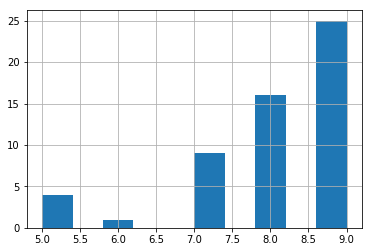

In [23]:
training_data_df[BEST_EPOCH].hist()

In [24]:
training_data_df[TOTAL_DURATION].describe()

count     55.000000
mean     321.381818
std       20.631234
min      294.000000
25%      299.000000
50%      335.000000
75%      338.000000
max      351.000000
Name: Total_Duration(s), dtype: float64

In [25]:
training_data_df.groupby([TRAINING_NUMBER]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Training_Number,,,,,,,,
0,55.0,0.813483,0.005852,0.797399,0.809756,0.813735,0.81729,0.827493


In [26]:
rp.summary_cont(training_data_df[TEST_F1_MEASURE])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Test_F1_Measure,55.0,0.813483,0.005852,0.000789,0.811901,0.815065


In [27]:
rp.summary_cont(training_data_df.groupby(EMBEDDING))[TEST_F1_MEASURE]

,N,Mean,SD,SE,95% Conf.,Interval
Embedding,,,,,,
No,6,0.810289,0.005901,0.002409,0.805568,0.815011
fasttext,14,0.811253,0.005446,0.001456,0.808400,0.814106
glove,7,0.818670,0.006551,0.002476,0.813817,0.823524
wang2vec,14,0.814103,0.006086,0.001627,0.810915,0.817291
word2vec,14,0.813866,0.004148,0.001109,0.811693,0.816039


In [28]:
# Calculating effect size
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

def print_anova(parameter):
    # Fits the model with the interaction term
    # This will also automatically include the main effects for each factor
    model = ols('Test_F1_Measure ~ C({0})'.format(parameter), training_data_df).fit()
    # Seeing if the overall model is significant
    print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .20f}")
    print(model.summary())
    res = sm.stats.anova_lm(model, typ= 2)
    print(res)
    print(anova_table(res))
    mc = statsmodels.stats.multicomp.MultiComparison(training_data_df[TEST_F1_MEASURE], training_data_df[parameter])
    mc_results = mc.tukeyhsd()
    print(mc_results)

In [29]:
print_anova(EMBEDDING)

Overall model F( 4, 50) =  2.682, p =  0.04200980179261123298
                            OLS Regression Results                            
Dep. Variable:        Test_F1_Measure   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     2.682
Date:                Tue, 13 Aug 2019   Prob (F-statistic):             0.0420
Time:                        10:04:27   Log-Likelihood:                 210.56
No. Observations:                  55   AIC:                            -411.1
Df Residuals:                      50   BIC:                            -401.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

In [30]:
training_data_df[(training_data_df.Embedding == 'wang2vec') & (training_data_df.Embedding_Type == 'skip') & (training_data_df.Representation == 'ELMo+Embeddings')]

,Training_ID,Model,Representation,Embedding,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
26,harem-ft1epoch_ELMo+Embeddings_wang2vec_skip_0_0,harem-ft1epoch,ELMo+Embeddings,wang2vec,skip,0,0,7,10,0:05:05.238023,305.0,30.5,0.994447,0.994850,0.937244,0.926375,0.931778,23.596941,0.978800,0.981095,0.810945,0.831633,0.821159,95.381125,0.978116,0.979887,0.819639,0.802671,0.811066,114.947017
58,harem-ft_ELMo+Embeddings_wang2vec_skip_0_0,harem-ft,ELMo+Embeddings,wang2vec,skip,0,0,8,10,0:05:00.883225,300.0,30.0,0.996720,0.996966,0.961957,0.954693,0.958311,16.613936,0.978909,0.980876,0.800000,0.836735,0.817955,114.745159,0.977066,0.978672,0.814538,0.800668,0.807543,142.074917
101,harem_ELMo+Embeddings_wang2vec_skip_0_0,harem,ELMo+Embeddings,wang2vec,skip,0,0,9,10,0:04:58.248330,298.0,29.8,0.994828,0.995220,0.941304,0.934196,0.937737,21.351368,0.977817,0.980111,0.814070,0.826531,0.820253,114.949970,0.978972,0.980773,0.833790,0.812354,0.822933,131.898220
